In [65]:
import pandas as pd
import numpy as np

In [94]:
data = pd.read_csv('my-new-set.csv')
data.head()

,n_of_individual_projects,motivation_r,relationship_with_others_r,communication_skills_r,task_management_r,salary(thousand kzt),total_rating,promoted
0,2.0,0.200000,0.200000,0.200000,0.200000,100.0,0.800000,0.0
1,3.0,0.500000,0.500000,0.500000,0.500000,150.0,0.700000,1.0
2,3.0,0.907390,0.880383,0.886172,0.854583,86.0,0.717144,0.0
3,0.0,0.954438,0.951636,0.656876,0.959900,441.0,0.947162,0.0
4,1.0,0.677607,0.975069,0.532699,0.451263,385.0,0.458558,0.0


In [69]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='promoted', axis=1);
y = data['promoted']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Gradient Boosting

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
import pickle
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
y_gb_pred = gb.predict(x_test)

In [71]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_gb_pred))

Accuracy: 0.9534883720930233


In [72]:
# saving gradient boosting
with open('model_gb', 'wb') as files:
    pickle.dump(gb, files)

# Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(x_train, y_train)
y_rf_pred = rf.predict(x_test)

In [74]:
print("Accuracy:",metrics.accuracy_score(y_test, y_rf_pred))

Accuracy: 0.9435215946843853


In [75]:
# saving random forest
with open('model_rf', 'wb') as files:
    pickle.dump(rf, files)

# Keras Sequential

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [77]:
def dataframe_to_dataset(data):
    data = data.copy()
    labels = data.pop("promoted")
    ds = tf.data.Dataset.from_tensor_slices((dict(data), labels))
    ds = ds.shuffle(buffer_size=len(data))
    return ds

In [78]:
val_dataframe = data.sample(frac=0.2, random_state=1337)
train_dataframe = data.drop(val_dataframe.index)

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [79]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [80]:
from tensorflow.keras.layers import Normalization

def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature


In [81]:
# Numerical features
salary = keras.Input(shape=(1,), name="salary(thousand kzt)")
n_of_individual_projects = keras.Input(shape=(1,), name="n_of_individual_projects")
motivation_r = keras.Input(shape=(1,), name="motivation_r")
relationship_with_others_r = keras.Input(shape=(1,), name="relationship_with_others_r")
communication_skills_r = keras.Input(shape=(1,), name="communication_skills_r")
task_management_r = keras.Input(shape=(1,), name="task_management_r")
total_rating = keras.Input(shape=(1,), name="total_rating")

all_inputs = [
    salary,
    n_of_individual_projects,
    motivation_r,
    relationship_with_others_r,
    communication_skills_r,
    task_management_r,
    total_rating,
]


# Numerical features
salary_encoded = encode_numerical_feature(salary, "salary(thousand kzt)", train_ds)
noip_encoded = encode_numerical_feature(n_of_individual_projects, "n_of_individual_projects", train_ds)
mr_encoded = encode_numerical_feature(motivation_r, "motivation_r", train_ds)
rwo_encoded = encode_numerical_feature(relationship_with_others_r, "relationship_with_others_r", train_ds)
cs_encoded = encode_numerical_feature(communication_skills_r, "communication_skills_r", train_ds)
tm_encoded = encode_numerical_feature(task_management_r, "task_management_r", train_ds)
tr_encoded = encode_numerical_feature(total_rating, "total_rating", train_ds)

all_features = layers.concatenate(
    [
        salary_encoded,
        noip_encoded,
        mr_encoded,
        rwo_encoded,
        cs_encoded,
        tm_encoded,
        tr_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [82]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
38/38 [==============================] - 1s 5ms/step - loss: 0.7397 - accuracy: 0.5033 - val_loss: 0.6085 - val_accuracy: 0.7967
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5522 - accuracy: 0.7488 - val_loss: 0.4586 - val_accuracy: 0.9167
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.4399 - accuracy: 0.8369 - val_loss: 0.3657 - val_accuracy: 0.9233
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.8860 - val_loss: 0.3058 - val_accuracy: 0.9333
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.9002 - val_loss: 0.2677 - val_accuracy: 0.9333
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2917 - accuracy: 0.9085 - val_loss: 0.2399 - val_accuracy: 0.9333
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2660 - accuracy: 0.9143 - val_loss: 0.2214 - val_accuracy: 0.9333
Epoch 8/50
38/38 [==

In [83]:
# model.save('keras.h5')

In [93]:
# model.summary()

In [85]:
sample = {
    "salary(thousand kzt)": 400,
    "n_of_individual_projects": 4,
    "motivation_r": 1,
    "relationship_with_others_r": 0.8,
    "communication_skills_r": 0.9,
    "task_management_r": 0.8,
    "total_rating": 0.9,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This employee had a %.1f percent probability "
    "of being promoted, as evaluated by our model." % (100 * predictions[0][0],)
)

This employee had a 85.3 percent probability of being promoted, as evaluated by our model.


In [86]:
# prediction for y_test with keras
y_keras_pred = []
for i in tf.convert_to_tensor(x_test):
    item = i.numpy()
    sample = {
        "n_of_individual_projects": item[0],
        "motivation_r": item[1],
        "relationship_with_others_r": item[2],
        "communication_skills_r": item[3],
        "task_management_r": item[4],
        "salary(thousand kzt)": item[5],
        "total_rating": item[6],
    }

    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = model.predict(input_dict)
    y_keras_pred.append(round(predictions[0][0]))

In [87]:
# y_keras_pred

# Metrics

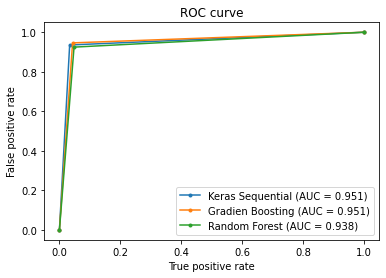

In [88]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_keras_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

nn_fpr_gb, nn_tpr_gb, nn_thresholds_gb = roc_curve(y_test, y_gb_pred)
auc_gb = auc(nn_fpr_gb, nn_tpr_gb)

nn_fpr_rf, nn_tpr_rf, nn_thresholds_rf = roc_curve(y_test, y_rf_pred)
auc_rf = auc(nn_fpr_rf, nn_tpr_rf)

plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Keras Sequential (AUC = %0.3f)' % auc_keras)
plt.plot(nn_fpr_gb, nn_tpr_gb, marker='.', label='Gradien Boosting (AUC = %0.3f)' % auc_gb)
plt.plot(nn_fpr_rf, nn_tpr_rf, marker='.', label='Random Forest (AUC = %0.3f)' % auc_rf)
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')
plt.title('ROC curve')
plt.legend()

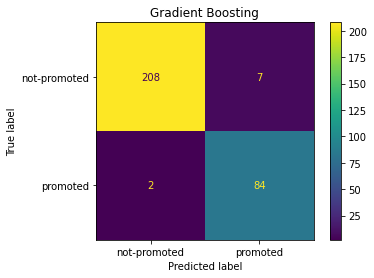

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_gb = confusion_matrix(y_test, y_gb_pred)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=['not-promoted', 'promoted'])
disp_gb.plot()
plt.title('Gradient Boosting')
plt.show()

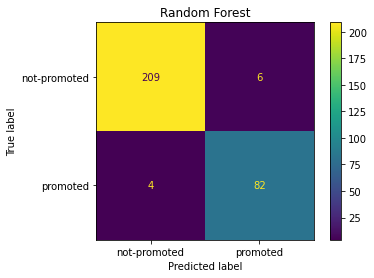

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_rf = confusion_matrix(y_test, y_rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['not-promoted', 'promoted'])
disp_rf.plot()
plt.title('Random Forest')
plt.show()

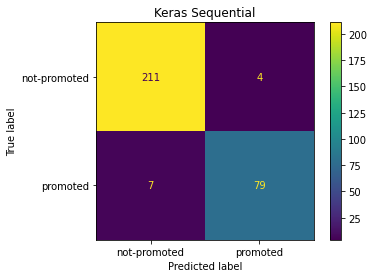

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_keras = confusion_matrix(y_test, y_keras_pred)
disp_keras = ConfusionMatrixDisplay(confusion_matrix=cm_keras, display_labels=['not-promoted', 'promoted'])
disp_keras.plot()
plt.title('Keras Sequential')
plt.show()

In [28]:
# pip install yellowbrick

C:\Users\zhanm\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


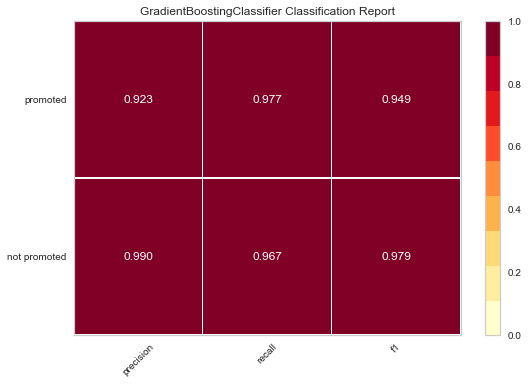

<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

In [28]:
from yellowbrick.classifier import ClassificationReport

classes = ["not promoted", "promoted"]

visualizer = ClassificationReport(gb, classes=classes)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

C:\Users\zhanm\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


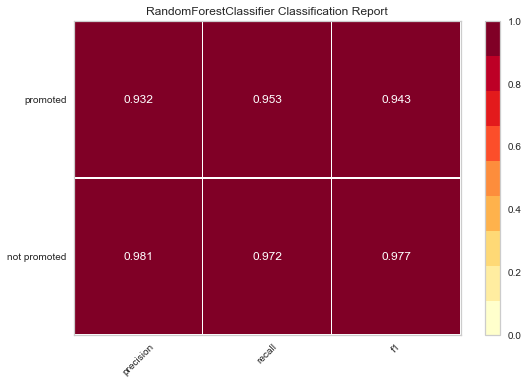

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [29]:
visualizer = ClassificationReport(rf, classes=classes)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

<AxesSubplot:>

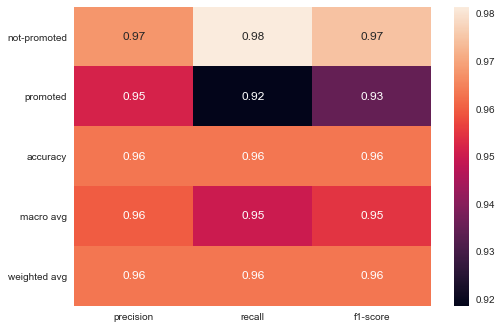

In [30]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
classes = ["not-promoted", "promoted"]

clf_report = classification_report(y_test, y_keras_pred, target_names=classes, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)